<a href="https://colab.research.google.com/github/Lewis34cs/fb_prophet_blog_notebook/blob/main/blog_prophet_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [112]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_components

In [86]:
# Setting params for plots
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

This dataset was retrieved from FRED and then uploaded into my Google Drive.

- Link to the original dataset can be found [`here`](https://fred.stlouisfed.org/series/PCU481111481111)


- You can also view and download the cleaned csv file on my [`Github page`](https://github.com/Lewis34cs/fb_prophet_blog_notebook)

In [87]:
# Loading in dataset
df = pd.read_csv('/content/drive/MyDrive/gdrive/datasets/air_passenger_clean.csv')

The 'DATE' column is in a monthly start format

In [88]:
df.head(5)

,DATE,PCU481111481111
0,1989-12-01,100.0
1,1990-01-01,101.0
2,1990-02-01,104.5
3,1990-03-01,106.9
4,1990-04-01,106.5


In [89]:
# Confirming that no dates exist past 2019-12-01
df.tail()

,DATE,PCU481111481111
356,2019-08-01,290.8
357,2019-09-01,279.7
358,2019-10-01,293.3
359,2019-11-01,287.7
360,2019-12-01,307.9


In [96]:
# checking to see if there are any null values in the dataframe
df.isna().sum()

ds    0
y     0
dtype: int64

In order to Prophet to be able to use this dataset, we must change the column names to 'ds' (the datetime column) and 'y' (the value we are trying to predict.

In [90]:
# Setting column names to required column names to be able to work with Prophet
df.columns = ['ds', 'y']

In [91]:
# Setting 'ds' column as a datetime object
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      361 non-null    datetime64[ns]
 1   y       361 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [93]:
df.head()

,ds,y
0,1989-12-01,100.0
1,1990-01-01,101.0
2,1990-02-01,104.5
3,1990-03-01,106.9
4,1990-04-01,106.5


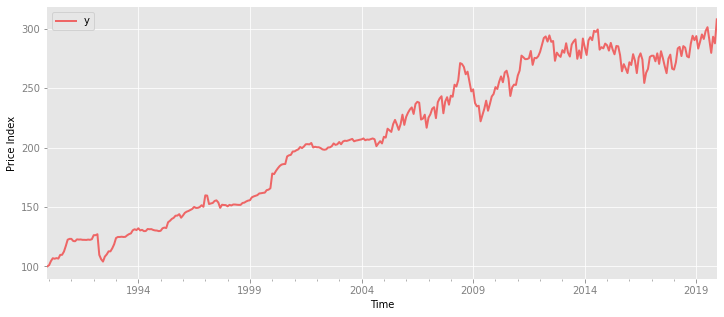

In [94]:
# plotting the dataframe
ax = df.plot(x='ds', y='y', figsize=(12,5))
ax.set_xlabel('Time')
ax.set_ylabel('Price Index');

In [95]:
# how many months we want the prophet model to predict
nobs = 12

In [97]:
# We want to predict 1 year, so we will make the test set contain the last year
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]

In [98]:
print(f"Length of dataframe: {len(df)}\n"
      f"Length of train set: {len(train)}\n"
      f"Length of test set: {len(test)}")

Length of dataframe: 361
Length of train set: 349
Length of test set: 12


In [129]:
# Creating an instance of the Prophet model
prophet = Prophet(seasonality_mode='multiplicative', interval_width=0.95)

# fitting Prophet model to the train set
prophet.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
# creating a dataframe to hold predictions for our model
future = prophet.make_future_dataframe(periods=nobs, freq='MS', include_history=True)

In [131]:
future

,ds
0,1989-12-01
1,1990-01-01
2,1990-02-01
3,1990-03-01
4,1990-04-01
...,...
356,2019-08-01
357,2019-09-01
358,2019-10-01
359,2019-11-01


In [132]:
# creating variable named 'forecast' to combine future dataframe with the predictions
forecast = prophet.predict(future)

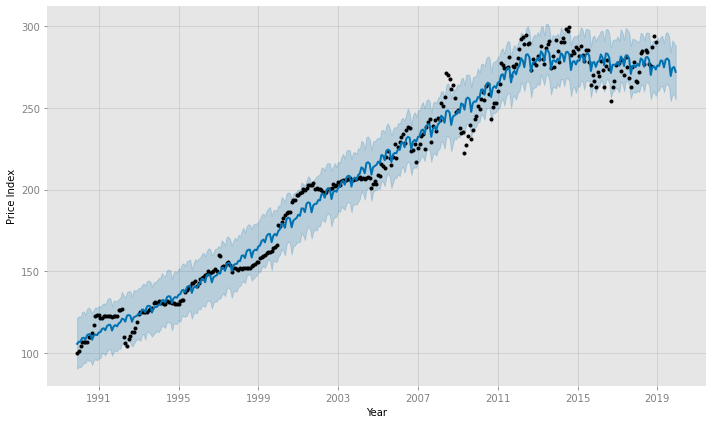

In [133]:
# plotting the forecasted results
fig1 = prophet.plot(forecast, xlabel='Year', ylabel='Price Index')

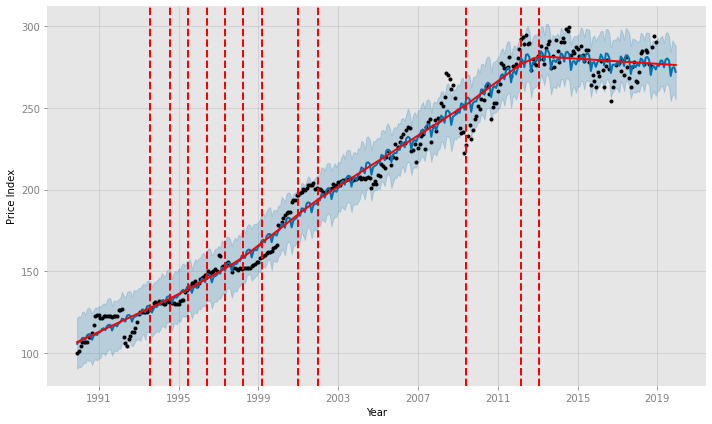

In [134]:
# plotting the forecasted results
fig1 = prophet.plot(forecast, xlabel='Year', ylabel='Price Index')

# viewing the points in time where the trajectory of the price index changed
add_cp = add_changepoints_to_plot(fig1.gca(), prophet, forecast)

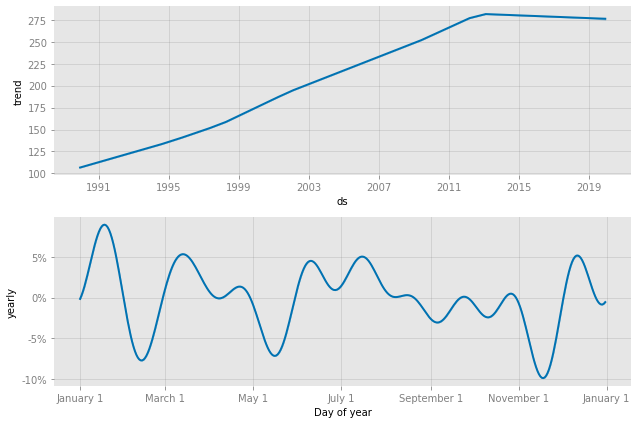

In [135]:
# Viewing the trend and seasonality 
prophet.plot_components(forecast);

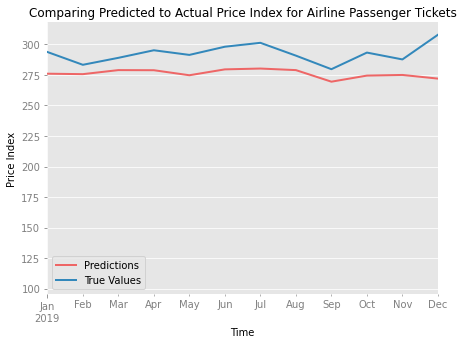

In [136]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(7,5),
                   title='Comparing Predicted to Actual Price Index for Airline Passenger Tickets')
test.plot(x='ds', y='y', label='True Values', ax=ax, xlim=['2019-01-01', '2019-12-01'])
ax.set_ylabel('Price Index')
ax.set_xlabel('Time');

### Evaluating Our Model's Performance

In [137]:
y_pred = forecast[-nobs:]['yhat']
y_true = test['y']

In [138]:
rmse(y_pred, y_true)

17.93188616577804

In [125]:
rmse_df = pd.DataFrame(columns=['additive', 'multiplicative'], index=['rmse'])

In [139]:
rmse_df['multiplicative'] = rmse(y_pred, y_true)

In [140]:
rmse_df

,additive,multiplicative
rmse,17.813678,17.931886


In [109]:
test['y'].describe()

count     12.000000
mean     292.625000
std        7.647118
min      279.700000
25%      288.675000
50%      292.350000
75%      295.925000
max      307.900000
Name: y, dtype: float64

In [114]:
def mape(y_pred, y_true):
  """
  Definition:
  The mean absolute percentage error (MAPE) is a statistical measure of how 
  accurate a forecast system is. It measures this accuracy as a percentage, and 
  can be calculated as the average absolute percent error for each time period 
  minus actual values divided by actual values.

  Args:
  y_pred: Required. An array of predicted values.
  y_true: Required. An array of the test set's values.

  Returns:
  The mean-absolute-percentage error
  """
  
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [115]:
mape(y_pred, y_true)

5.529395178142538

### Using Cross Validation to Evaluate Our Model's Performance

In [116]:
# Initial
initial = 365 * 5 
initial = str(initial) + ' days'

# Period
period = 365 * 5
period = str(period) + ' days'


# Horizon
horizon = 365
horizon = str(horizon) + ' days'

In [117]:
df_cv = cross_validation(prophet, horizon, period, initial,)

INFO:fbprophet:Making 5 forecasts with cutoffs between 1997-12-06 00:00:00 and 2017-12-01 00:00:00


In [118]:
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,57 days,69.940451,8.363041,7.618172,0.039830,0.045036,0.666667
1,58 days,83.673806,9.147339,8.204577,0.039887,0.045036,0.666667
2,59 days,66.811361,8.173822,6.878114,0.033104,0.028796,0.666667
3,61 days,64.383021,8.023903,6.507725,0.031393,0.024685,0.666667
4,62 days,65.743807,8.108255,6.797940,0.032494,0.025707,0.666667


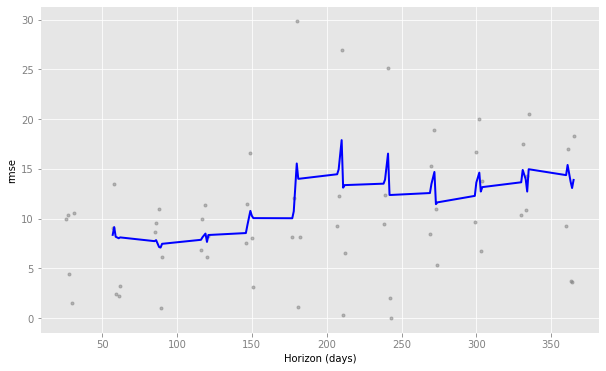

In [123]:
plot_cross_validation_metric(df_cv, metric='rmse');

The above plot tells us what the optimal number of days to predict off of our dataset is. Typically, this works better when using a dataframe that has daily values because it gives the model more to look at. For the sake of this notebook, we can see that predicting half a year out or less may give us a lower rmse value for our model's predictions.